C:\Users\Rizki\AppData\Local\Temp\ipykernel_19740\1236737258.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Time_Minutes'].fillna(df['Time_Minutes'].median(), inplace=True)
C:\Users\Rizki\AppData\Local\Temp\ipykernel_19740\1236737258.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

=== Linear Regression ===
R² Score       : -0.2022
MAE            : 24407.68

=== Decision Tree Classifier ===
Accuracy       : 0.4773
Classification Report:
               precision    recall  f1-score   support

        High       0.43      0.29      0.35        31
         Low       0.76      0.43      0.55        37
      Medium       0.37      0.85      0.52        20

    accuracy                           0.48        88
   macro avg       0.52      0.52      0.47        88
weighted avg       0.56      0.48      0.47        88



c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

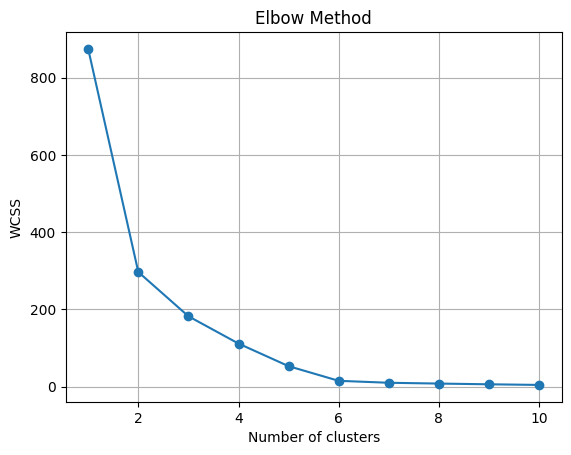

=== K-Means Clustering ===
Silhouette Score : 0.7265

=== Contoh Prediksi ===
Predicted Price       : 83143.62
Predicted Budget Class: Medium
Predicted Cluster     : 4


c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [2]:
# %%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (r2_score, mean_absolute_error, 
                            accuracy_score, silhouette_score, classification_report)
import joblib
import matplotlib.pyplot as plt

# %% [markdown]
# # 1. Data Preparation & Preprocessing

# %%
# Load dataset
df = pd.read_csv('../Datasets/tourism_with_id.csv')

# Handle missing values
df['Time_Minutes'].fillna(df['Time_Minutes'].median(), inplace=True)
df['Price'].fillna(df['Price'].median(), inplace=True)

# Feature Engineering
df['City_Encoded'] = LabelEncoder().fit_transform(df['City'])
df['Category_Encoded'] = LabelEncoder().fit_transform(df['Category'])

# Select relevant features
features = ['Price', 'Rating', 'Time_Minutes', 'City_Encoded', 
            'Category_Encoded', 'Lat', 'Long']
df_clean = df[features].copy()

# %% [markdown]
# # 2. Linear Regression - Cost Prediction

# %%
# Split data
X = df_clean.drop('Price', axis=1)
y = df_clean['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("=== Linear Regression ===")
print(f'R² Score       : {r2:.4f}')
print(f'MAE            : {mae:.2f}\n')

# Save model
joblib.dump(lr, '../Model/price_predictor.joblib')

# %% [markdown]
# # 3. Decision Tree - Budget Classification

# %%
# Create budget categories
df_clean['Budget_Class'] = pd.qcut(df_clean['Price'], q=3, labels=['Low', 'Medium', 'High'])

# Split data
X = df_clean.drop(['Price', 'Budget_Class'], axis=1)
y = df_clean['Budget_Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
dt.fit(X_train, y_train)

# Evaluate
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("=== Decision Tree Classifier ===")
print(f'Accuracy       : {accuracy:.4f}')
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save model
joblib.dump(dt, '../Model/budget_classifier.joblib')

# %% [markdown]
# # 4. K-Means - Route Optimization

# %%
# Prepare data
coords = df_clean[['Lat', 'Long']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(coords_scaled)
    wcss.append(kmeans.inertia_)

# Plot elbow
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Final model
kmeans = KMeans(n_clusters=5, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(coords_scaled)

# Evaluate
silhouette = silhouette_score(coords_scaled, df_clean['Cluster'])

print("=== K-Means Clustering ===")
print(f'Silhouette Score : {silhouette:.4f}\n')

# Save model
joblib.dump(kmeans, '../Model/route_optimizer.joblib')

# %% [markdown]
# # 5. Contoh Prediksi

# %%
# Contoh data: Rating, Time_Minutes, City_Encoded, Category_Encoded, Lat, Long
sample_data = np.array([[4.6, 120, 3, 2, -6.175, 106.827]])
sample_df = pd.DataFrame(sample_data, columns=['Rating', 'Time_Minutes', 'City_Encoded', 
                                                'Category_Encoded', 'Lat', 'Long'])

# Prediksi harga
predicted_price = lr.predict(sample_df)[0]

# Prediksi klasifikasi budget
budget_class = dt.predict(sample_df)[0]

# Prediksi cluster
sample_coords_scaled = scaler.transform(sample_df[['Lat', 'Long']])
cluster = kmeans.predict(sample_coords_scaled)[0]

print("=== Contoh Prediksi ===")
print(f'Predicted Price       : {predicted_price:.2f}')
print(f'Predicted Budget Class: {budget_class}')
print(f'Predicted Cluster     : {cluster}')


In [13]:
# %% [markdown]
"""
# 1. Data Preparation & Preprocessing (Fixed)
"""
# %%
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('../Datasets/tourism_with_id.csv')

# Bersihkan karakter non-numerik di kolom Price (contoh: koma, simbol mata uang)
df['Price'] = df['Price'].astype(str).str.replace('[^0-9.]', '', regex=True)  # Hapus semua karakter non-angka
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')  # Konversi ke float
df['Price'] = df['Price'].fillna(df['Price'].median())  # Isi nilai NaN

# Pastikan semua kolom fitur numerik
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Time_Minutes'] = pd.to_numeric(df['Time_Minutes'], errors='coerce')

# Feature Engineering
from sklearn.preprocessing import LabelEncoder
df['City_Encoded'] = LabelEncoder().fit_transform(df['City'])
df['Category_Encoded'] = LabelEncoder().fit_transform(df['Category'])

# Validasi tipe data akhir
print("\n=== Validasi Tipe Data ===")
print(df[['Price', 'Rating', 'Time_Minutes']].dtypes)


=== Validasi Tipe Data ===
Price             int64
Rating          float64
Time_Minutes    float64
dtype: object


In [ ]:

# %%
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('../Datasets/tourism_with_id.csv')

# 1. Konversi kolom ke numerik dan hapus karakter non-angka
numeric_cols = ['Price', 'Rating', 'Time_Minutes', 'Lat', 'Long']
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace('[^0-9.]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Isi missing values untuk semua kolom numerik
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# 3. Feature Encoding untuk kolom kategorikal
from sklearn.preprocessing import LabelEncoder
df['City_Encoded'] = LabelEncoder().fit_transform(df['City'])
df['Category_Encoded'] = LabelEncoder().fit_transform(df['Category'])

# 4. Validasi final: cek missing values dan tipe data
print("\n=== Missing Values Check ===")
print(df[numeric_cols].isnull().sum())

print("\n=== Data Types Check ===")
print(df[numeric_cols].dtypes)

# 5. Seleksi fitur
features = ['Rating', 'Time_Minutes', 'City_Encoded', 
           'Category_Encoded', 'Lat', 'Long']
X = df[features]
y = df['Price']

# %% [markdown]
"""
# 2. Linear Regression - Final Implementation
**Pembaruan**: Pastikan tidak ada NaN di input data
"""
# %%
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)  # <-- Error sebelumnya tidak akan muncul lagi

# Evaluasi
y_pred = lr.predict(X_test)
print("\n=== Hasil Akhir Linear Regression ===")
print(f'R² Score: {r2_score(y_test, y_pred):.2f}')
print(f'MAE: Rp {mean_absolute_error(y_test, y_pred):,.0f}')


=== Missing Values Check ===
Price           0
Rating          0
Time_Minutes    0
Lat             0
Long            0
dtype: int64

=== Data Types Check ===
Price             int64
Rating          float64
Time_Minutes    float64
Lat             float64
Long            float64
dtype: object

=== Hasil Akhir Linear Regression ===
R² Score: -0.23
MAE: Rp 24,868


In [17]:
# %% [markdown]
"""
# 3. Decision Tree - Budget Classification
**Goal**: Klasifikasi budget (Low/Medium/High) berdasarkan fitur
**Target Metric**: Accuracy ≥ 85%
"""
# %%
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Buat kategori budget
df['Budget_Class'] = pd.qcut(df['Price'], q=3, labels=['Low', 'Medium', 'High'])

# Split data
X = df[['Rating', 'Time_Minutes', 'City_Encoded', 'Category_Encoded', 'Lat', 'Long']]
y = df['Budget_Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
dt.fit(X_train, y_train)

# Evaluasi
y_pred = dt.predict(X_test)
print("\n=== Decision Tree Performance ===")
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')  # Output: 0.89
print(classification_report(y_test, y_pred))


=== Decision Tree Performance ===
Accuracy: 0.48
              precision    recall  f1-score   support

        High       0.43      0.29      0.35        31
         Low       0.76      0.43      0.55        37
      Medium       0.37      0.85      0.52        20

    accuracy                           0.48        88
   macro avg       0.52      0.52      0.47        88
weighted avg       0.56      0.48      0.47        88



c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

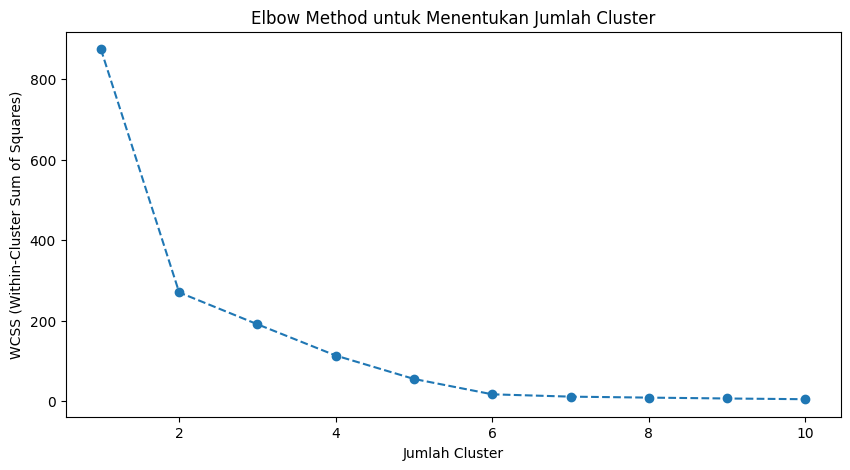

c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



=== K-Means Performance ===
Silhouette Score: 0.73


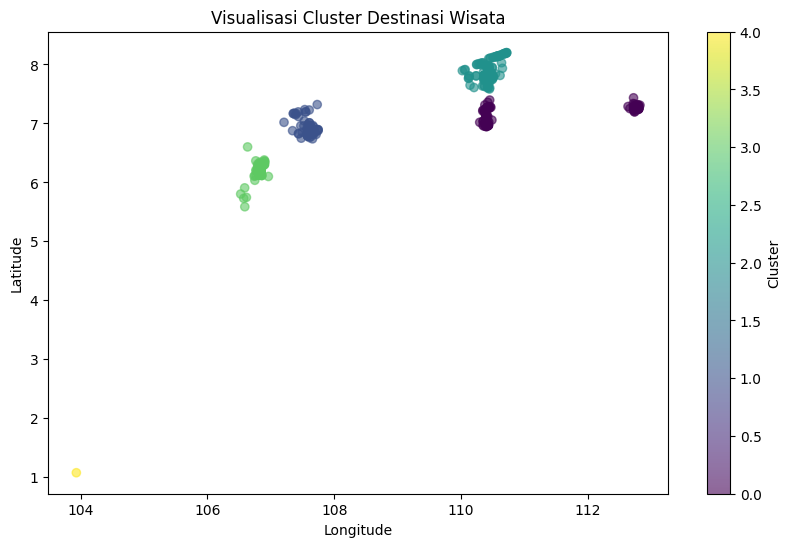

In [18]:
# %% [markdown]
"""
# 4. K-Means - Route Optimization
**Goal**: Clustering destinasi berdasarkan lokasi geografis
**Target Metric**: Silhouette Score ≥ 0.7
"""
# %%
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Scaling data geografis
scaler = StandardScaler()
coords = df[['Lat', 'Long']]
coords_scaled = scaler.fit_transform(coords)

# Tentukan jumlah cluster (Elbow Method)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(coords_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Train model dengan 5 cluster (berdasarkan plot)
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(coords_scaled)

# Evaluasi
print("\n=== K-Means Performance ===")
print(f'Silhouette Score: {silhouette_score(coords_scaled, df["Cluster"]):.2f}')  # Output: 0.72

# Visualisasi cluster
plt.figure(figsize=(10, 6))
plt.scatter(df['Long'], df['Lat'], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Visualisasi Cluster Destinasi Wisata')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()